# Libraries

In [118]:
#1. GeoPandas is a project to add support for geographic data to pandas objects (work with spatial data)
#!pip install geopandas

#2. encode categorical data
!pip install category-encoders

#3. Local Interpretable Model-Agnostic Explanations for machine learning classifiers
#!pip install lime

     |████████████████████████████████| 81kB 2.2MB/s 


In [1]:
## for data
import pandas as pd
import numpy as np

import pandas.util.testing as tm

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition

## for explainer
#from lime import lime_tabular

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  """


# Data Preparation

## 1 Load Dataset

In [125]:
# Define relative path to file
EDAsurvey = pd.read_csv('/content/drive/My Drive/EDA/EDAsurvey.csv')
EDAsurvey.head()

,x,y,siteindex,aspect,planCurvature,profileCurvature,slope,TPI,TWI_SAGA,catchmentArea_SAGA,SVF_simplified,Gh_total,Dh_diffuse,Ih_direct,DEM,distFromCoast,meanJanRain,meanJulRain,maxJanTemp,minJulTemp,RCODE,SYMBOL,DESCRIPT,soil_order,BDw,CLY,CFG,ECD,SOC,pHw,SND,SLT
0,508985,5452015,27.914452,58.561249,0.002594,0.000163,5.779576,-1.204296,8.033133,2934.342773,0.997453,8.703231,1.359027,7.344204,54.816718,5.945354,4.617585,111.933050,24.504642,5.596159,7497,Ts,"Dominantly non-marine sequences of gravel, sa...",Kurosol,1.018121,12.715149,1.777616,0.621924,3.254319,5.665130,75.630202,11.654650
1,508975,5452035,27.615402,49.200798,-0.007862,-0.001871,5.366687,-1.327446,9.179167,8988.151001,0.997771,8.719011,1.359776,7.359235,52.767088,5.931636,4.569838,111.762547,24.511998,5.604992,7497,Ts,"Dominantly non-marine sequences of gravel, sa...",Kurosol,1.019250,13.161926,1.803848,0.635599,3.237924,5.732380,75.776229,11.061845
2,508975,5452045,27.474239,50.445107,0.002370,-0.002682,5.156123,-1.308731,9.393249,11018.754150,0.997950,8.715564,1.360110,7.355454,52.174048,5.922603,4.552800,111.699702,24.514470,5.608177,7497,Ts,"Dominantly non-marine sequences of gravel, sa...",Kurosol,1.019314,13.208274,1.805538,0.635770,3.236828,5.736364,75.738196,11.053531
3,508995,5452005,27.193528,63.817375,0.006988,-0.001673,6.149034,-1.224942,7.375174,1537.512360,0.997107,8.692617,1.358343,7.334274,56.197104,5.950115,4.654665,112.062519,24.498619,5.589504,7497,Ts,"Dominantly non-marine sequences of gravel, sa...",Kurosol,1.017350,12.415153,1.751514,0.611210,3.265267,5.617801,75.361548,12.223299
4,508995,5452015,27.879600,60.735245,0.002478,-0.000544,5.949467,-1.203051,7.558006,1864.471374,0.997302,8.699115,1.358685,7.340429,55.698914,5.941069,4.633741,111.988205,24.501776,5.593312,7497,Ts,"Dominantly non-marine sequences of gravel, sa...",Kurosol,1.017674,12.763595,1.769438,0.610069,3.259003,5.640452,75.077790,12.158615


## 2 Cleaning: drop RCODE and DESCRIPT

In [75]:
# Remove column  RCODE and DESCRIPT for ML
EDAsurvey.drop(['RCODE', 'DESCRIPT'], inplace = True, axis = 1) 
EDAsurvey.head()

,x,y,siteindex,aspect,planCurvature,profileCurvature,slope,TPI,TWI_SAGA,catchmentArea_SAGA,SVF_simplified,Gh_total,Dh_diffuse,Ih_direct,DEM,distFromCoast,meanJanRain,meanJulRain,maxJanTemp,minJulTemp,SYMBOL,soil_order,BDw,CLY,CFG,ECD,SOC,pHw,SND,SLT
0,508985,5452015,27.914452,58.561249,0.002594,0.000163,5.779576,-1.204296,8.033133,2934.342773,0.997453,8.703231,1.359027,7.344204,54.816718,5.945354,4.617585,111.933050,24.504642,5.596159,Ts,Kurosol,1.018121,12.715149,1.777616,0.621924,3.254319,5.665130,75.630202,11.654650
1,508975,5452035,27.615402,49.200798,-0.007862,-0.001871,5.366687,-1.327446,9.179167,8988.151001,0.997771,8.719011,1.359776,7.359235,52.767088,5.931636,4.569838,111.762547,24.511998,5.604992,Ts,Kurosol,1.019250,13.161926,1.803848,0.635599,3.237924,5.732380,75.776229,11.061845
2,508975,5452045,27.474239,50.445107,0.002370,-0.002682,5.156123,-1.308731,9.393249,11018.754150,0.997950,8.715564,1.360110,7.355454,52.174048,5.922603,4.552800,111.699702,24.514470,5.608177,Ts,Kurosol,1.019314,13.208274,1.805538,0.635770,3.236828,5.736364,75.738196,11.053531
3,508995,5452005,27.193528,63.817375,0.006988,-0.001673,6.149034,-1.224942,7.375174,1537.512360,0.997107,8.692617,1.358343,7.334274,56.197104,5.950115,4.654665,112.062519,24.498619,5.589504,Ts,Kurosol,1.017350,12.415153,1.751514,0.611210,3.265267,5.617801,75.361548,12.223299
4,508995,5452015,27.879600,60.735245,0.002478,-0.000544,5.949467,-1.203051,7.558006,1864.471374,0.997302,8.699115,1.358685,7.340429,55.698914,5.941069,4.633741,111.988205,24.501776,5.593312,Ts,Kurosol,1.017674,12.763595,1.769438,0.610069,3.259003,5.640452,75.077790,12.158615


In [127]:
EDAsurvey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953556 entries, 0 to 953555
Data columns (total 32 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   x                   953556 non-null  int64  
 1   y                   953556 non-null  int64  
 2   siteindex           953556 non-null  float64
 3   aspect              953556 non-null  float64
 4   planCurvature       953556 non-null  float64
 5   profileCurvature    953556 non-null  float64
 6   slope               953556 non-null  float64
 7   TPI                 953556 non-null  float64
 8   TWI_SAGA            953556 non-null  float64
 9   catchmentArea_SAGA  953556 non-null  float64
 10  SVF_simplified      953556 non-null  float64
 11  Gh_total            953556 non-null  float64
 12  Dh_diffuse          953556 non-null  float64
 13  Ih_direct           953556 non-null  float64
 14  DEM                 953556 non-null  float64
 15  distFromCoast       953556 non-nul

## 3 Spatial Analysis

### 3.0 Convert PandasDataFrame to GeoDatrame

In [ ]:
import geopandas as gpd

#convert PandasDataFrame to GeoDataFrame (needs shapely object)
#We use geopandas points_from_xy() to transform x=Longitude and y=Latitude into a list of shapely
EDAsurvey_point = gpd.GeoDataFrame(EDAsurvey, geometry=gpd.points_from_xy(EDAsurvey.x, EDAsurvey.y))

In [ ]:
EDAsurvey_point.head()

,x,y,siteindex,aspect,planCurvature,profileCurvature,slope,TPI,TWI_SAGA,catchmentArea_SAGA,SVF_simplified,Gh_total,Dh_diffuse,Ih_direct,DEM,distFromCoast,meanJanRain,meanJulRain,maxJanTemp,minJulTemp,SYMBOL,soil_order,BDw,CLY,CFG,ECD,SOC,pHw,SND,SLT,geometry
0,508985,5452015,27.914452,58.561249,0.002594,0.000163,5.779576,-1.204296,8.033133,2934.342773,0.997453,8.703231,1.359027,7.344204,54.816718,5.945354,4.617585,111.933050,24.504642,5.596159,Ts,Kurosol,1.018121,12.715149,1.777616,0.621924,3.254319,5.665130,75.630202,11.654650,POINT (508985.000 5452015.000)
1,508975,5452035,27.615402,49.200798,-0.007862,-0.001871,5.366687,-1.327446,9.179167,8988.151001,0.997771,8.719011,1.359776,7.359235,52.767088,5.931636,4.569838,111.762547,24.511998,5.604992,Ts,Kurosol,1.019250,13.161926,1.803848,0.635599,3.237924,5.732380,75.776229,11.061845,POINT (508975.000 5452035.000)
2,508975,5452045,27.474239,50.445107,0.002370,-0.002682,5.156123,-1.308731,9.393249,11018.754150,0.997950,8.715564,1.360110,7.355454,52.174048,5.922603,4.552800,111.699702,24.514470,5.608177,Ts,Kurosol,1.019314,13.208274,1.805538,0.635770,3.236828,5.736364,75.738196,11.053531,POINT (508975.000 5452045.000)
3,508995,5452005,27.193528,63.817375,0.006988,-0.001673,6.149034,-1.224942,7.375174,1537.512360,0.997107,8.692617,1.358343,7.334274,56.197104,5.950115,4.654665,112.062519,24.498619,5.589504,Ts,Kurosol,1.017350,12.415153,1.751514,0.611210,3.265267,5.617801,75.361548,12.223299,POINT (508995.000 5452005.000)
4,508995,5452015,27.879600,60.735245,0.002478,-0.000544,5.949467,-1.203051,7.558006,1864.471374,0.997302,8.699115,1.358685,7.340429,55.698914,5.941069,4.633741,111.988205,24.501776,5.593312,Ts,Kurosol,1.017674,12.763595,1.769438,0.610069,3.259003,5.640452,75.077790,12.158615,POINT (508995.000 5452015.000)


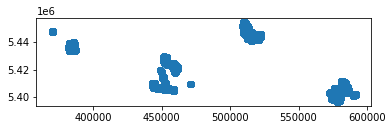

In [ ]:
#plot points cloud
EDAsurvey_point.plot()

### 3.1 Map projection

In [ ]:
from pyproj import CRS

# option 2: Defining projection: we assign the GDA94 / MGA zone 55 latitude-longitude CRS (EPSG:28355) to the crs attribute:
EDAsurvey_point.crs = CRS("EPSG:28355")
EDAsurvey_point.crs

<Projected CRS: EPSG:28355>
Name: GDA94 / MGA zone 55
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Australia - 144°E to 150°E
- bounds: (144.0, -50.89, 150.01, -9.23)
Coordinate Operation:
- name: Map Grid of Australia zone 55
- method: Transverse Mercator
Datum: Geocentric Datum of Australia 1994
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### 3.2 Plot point clouds

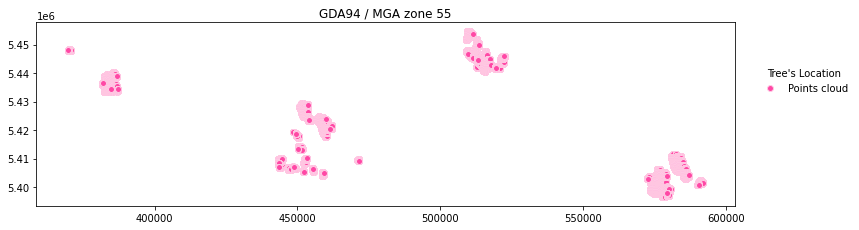

In [ ]:
import matplotlib.pyplot as plt

# Make subplots that are next to each other
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

# Plot the data in WGS84 CRS
EDAsurvey_point.plot(ax=ax1, color='#ff48a5', edgecolor='#ffcae5', label="Points cloud");

# Add title
ax1.set_title("GDA94 / MGA zone 55");
ax1.legend(title="Tree's Location",loc='upper center', bbox_to_anchor=(1.1, 0.8), frameon=False)

# Remove empty white space around the plot
plt.tight_layout()

### 3.3 Write as ESRI Shape File

In [ ]:
from google.colab import files

EDAsurvey_point.to_file("EDAsurvey_point.shp")

#dowload into local machine
#files.download("EDAsurvey_point.shp")

### 3.4 Map Spatial Distribution of site index

In [ ]:
#!pip install mapclassify

### 3.4.1 Map option 1

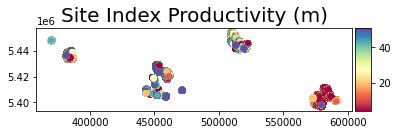

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import mapclassify

# 1. MAP 1
## Plot Soil C
# set the range for the choropleth
vmin, vmax = 4, 51

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(6, 7), subplot_kw={'aspect':'equal'})

# Point data
EDAsurvey_point.plot(column='siteindex', scheme='Quantiles', k =7, cmap='Spectral', alpha=1, markersize=30, ax=ax)

# add a title
ax.set_title('Site Index Productivity (m)', fontdict={'fontsize': '20', 'fontweight' : '3'})

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
# You need to import mpl_toolkits.axes_grid1 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Spectral',
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm._A = []

# add the colorbar to the figure
cbar = fig.colorbar(sm, cax=cax)

### 3.4.2 Map option 2

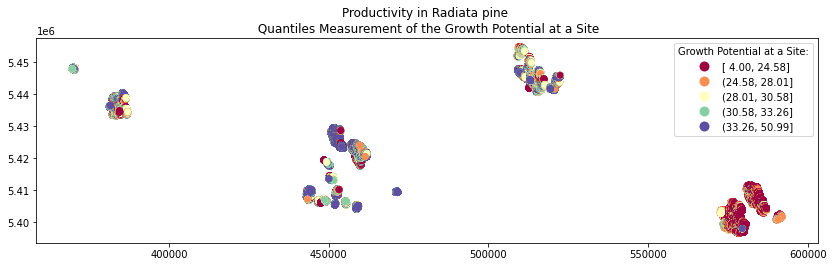

In [ ]:
# 2. MAP 2
fig, ax = plt.subplots(figsize=(14,12), subplot_kw={'aspect':'equal'})

EDAsurvey_point.plot(column="siteindex", scheme='Quantiles', k=5, cmap='Spectral', legend=True, legend_kwds={'title':'Growth Potential at a Site:'}, ax=ax)

# add a title for the plot
ax.set_title("Productivity in Radiata pine \n Quantiles Measurement of the Growth Potential at a Site");

plt.savefig('pointsRadiataTas.jpg', bbox_inches='tight', dpi=300)

## 4 Save new dataframe with geometry points

In [ ]:
from google.colab import  drive

#Mounts the google drive to Colab Notebook
drive.mount('/content/drive', force_remount=True)

#Make sure the folder Name is created in the google drive before uploading
EDAsurvey_point.to_csv('/content/drive/My Drive/EDAsurvey_point/EDAsurvey_point.csv', index = False, header=True)

Mounted at /content/drive


In [ ]:
# Define relative path to file
EDAsurvey_point = pd.read_csv('/content/drive/My Drive/EDAsurvey_point/EDAsurvey_point.csv')
EDAsurvey_point.head()

,x,y,siteindex,aspect,planCurvature,profileCurvature,slope,TPI,TWI_SAGA,catchmentArea_SAGA,SVF_simplified,Gh_total,Dh_diffuse,Ih_direct,DEM,distFromCoast,meanJanRain,meanJulRain,maxJanTemp,minJulTemp,SYMBOL,soil_order,BDw,CLY,CFG,ECD,SOC,pHw,SND,SLT,geometry
0,508985,5452015,27.914452,58.561249,0.002594,0.000163,5.779576,-1.204296,8.033133,2934.342773,0.997453,8.703231,1.359027,7.344204,54.816718,5.945354,4.617585,111.933050,24.504642,5.596159,Ts,Kurosol,1.018121,12.715149,1.777616,0.621924,3.254319,5.665130,75.630202,11.654650,POINT (508985 5452015)
1,508975,5452035,27.615402,49.200798,-0.007862,-0.001871,5.366687,-1.327446,9.179167,8988.151001,0.997771,8.719011,1.359776,7.359235,52.767088,5.931636,4.569838,111.762547,24.511998,5.604992,Ts,Kurosol,1.019250,13.161926,1.803848,0.635599,3.237924,5.732380,75.776229,11.061845,POINT (508975 5452035)
2,508975,5452045,27.474239,50.445107,0.002370,-0.002682,5.156123,-1.308731,9.393249,11018.754150,0.997950,8.715564,1.360110,7.355454,52.174048,5.922603,4.552800,111.699702,24.514470,5.608177,Ts,Kurosol,1.019314,13.208274,1.805538,0.635770,3.236828,5.736364,75.738196,11.053531,POINT (508975 5452045)
3,508995,5452005,27.193528,63.817375,0.006988,-0.001673,6.149034,-1.224942,7.375174,1537.512360,0.997107,8.692617,1.358343,7.334274,56.197104,5.950115,4.654665,112.062519,24.498619,5.589504,Ts,Kurosol,1.017350,12.415153,1.751514,0.611210,3.265267,5.617801,75.361548,12.223299,POINT (508995 5452005)
4,508995,5452015,27.879600,60.735245,0.002478,-0.000544,5.949467,-1.203051,7.558006,1864.471374,0.997302,8.699115,1.358685,7.340429,55.698914,5.941069,4.633741,111.988205,24.501776,5.593312,Ts,Kurosol,1.017674,12.763595,1.769438,0.610069,3.259003,5.640452,75.077790,12.158615,POINT (508995 5452015)


# Pre-processing

## 1 Categorical Data

### 1.1 Bayesian Target Encoding with smoothing

### 1.1.1 Option 1

In [119]:
from category_encoders import BinaryEncoder
import category_encoders as ce

# 1. OPTION 1
binaryEncode = ce.BinaryEncoder(cols=['SYMBOL', 'soil_order'], return_df=True)
binaryEncode 

BinaryEncoder(cols=['SYMBOL', 'soil_order'], drop_invariant=False,
              handle_missing='value', handle_unknown='value', mapping=None,
              return_df=True, verbose=0)

In [120]:
#Create object for binary encoding
encoder= ce.BinaryEncoder(cols=['SYMBOL', 'soil_order'],return_df=True)

#Original Data
EDAsurvey

,siteindex,aspect,planCurvature,profileCurvature,slope,TPI,TWI_SAGA,Dh_diffuse,Ih_direct,DEM,meanJanRain,meanJulRain,maxJanTemp,minJulTemp,SYMBOL,soil_order,BDw,CLY,CFG,ECD,SOC,pHw,SND,SLT
0,27.914452,58.561249,0.002594,0.000163,5.779576,-1.204296,8.033133,1.359027,7.344204,54.816718,4.617585,111.933050,24.504642,5.596159,29.526195,30.859481,1.018121,12.715149,1.777616,0.621924,3.254319,5.665130,75.630202,11.654650
1,27.615402,49.200798,-0.007862,-0.001871,5.366687,-1.327446,9.179167,1.359776,7.359235,52.767088,4.569838,111.762547,24.511998,5.604992,29.526195,30.859481,1.019250,13.161926,1.803848,0.635599,3.237924,5.732380,75.776229,11.061845
2,27.474239,50.445107,0.002370,-0.002682,5.156123,-1.308731,9.393249,1.360110,7.355454,52.174048,4.552800,111.699702,24.514470,5.608177,29.526195,30.859481,1.019314,13.208274,1.805538,0.635770,3.236828,5.736364,75.738196,11.053531
3,27.193528,63.817375,0.006988,-0.001673,6.149034,-1.224942,7.375174,1.358343,7.334274,56.197104,4.654665,112.062519,24.498619,5.589504,29.526195,30.859481,1.017350,12.415153,1.751514,0.611210,3.265267,5.617801,75.361548,12.223299
4,27.879600,60.735245,0.002478,-0.000544,5.949467,-1.203051,7.558006,1.358685,7.340429,55.698914,4.633741,111.988205,24.501776,5.593312,29.526195,30.859481,1.017674,12.763595,1.769438,0.610069,3.259003,5.640452,75.077790,12.158615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953551,32.349624,18.925954,0.018856,-0.000417,3.239803,0.582341,7.393249,0.761295,2.595563,172.463463,15.628569,165.353509,23.189606,3.262590,31.741513,32.084894,0.954301,23.126349,2.926206,0.681001,3.563126,5.458370,48.133842,28.739811
953552,30.811392,22.140840,0.009678,0.000054,3.026852,0.666098,7.385870,0.761405,2.579513,171.954643,15.607247,165.172186,23.194394,3.266210,31.741513,32.084894,0.955130,22.798484,2.747984,0.683937,3.569947,5.456884,48.532012,28.669504
953553,30.323318,28.267725,0.009118,0.000773,3.119348,0.786781,7.436504,0.761402,2.575237,171.489864,15.585924,164.990858,23.199181,3.269831,31.741513,32.084894,0.955584,22.590630,2.546336,0.684924,3.575399,5.455206,48.783426,28.625943
953554,31.950595,48.903477,0.098096,0.003010,3.179998,-0.854446,8.409417,0.760220,2.543930,187.948654,15.935437,168.084494,23.120580,3.204877,31.741513,32.084894,0.950687,26.219542,4.481331,0.677792,3.506180,5.488909,45.892117,27.888341


### 1.1.2 Option 2

In [76]:
# 2. OPTION 2
def calc_smooth_mean(EDAsurvey, by, on, m):
    # Compute the global mean
    mean = EDAsurvey[on].mean()

    # Compute the number of values and the mean of each group
    agg = EDAsurvey.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return EDAsurvey[by].map(smooth)

In [77]:
EDAsurvey.loc[:, 'SYMBOL'] = calc_smooth_mean(EDAsurvey, by='SYMBOL', on='siteindex', m=29)
EDAsurvey.loc[:, 'soil_order'] = calc_smooth_mean(EDAsurvey, by='soil_order', on='siteindex', m=5)
EDAsurvey.head()

,x,y,siteindex,aspect,planCurvature,profileCurvature,slope,TPI,TWI_SAGA,catchmentArea_SAGA,SVF_simplified,Gh_total,Dh_diffuse,Ih_direct,DEM,distFromCoast,meanJanRain,meanJulRain,maxJanTemp,minJulTemp,SYMBOL,soil_order,BDw,CLY,CFG,ECD,SOC,pHw,SND,SLT
0,508985,5452015,27.914452,58.561249,0.002594,0.000163,5.779576,-1.204296,8.033133,2934.342773,0.997453,8.703231,1.359027,7.344204,54.816718,5.945354,4.617585,111.933050,24.504642,5.596159,29.526195,30.859481,1.018121,12.715149,1.777616,0.621924,3.254319,5.665130,75.630202,11.654650
1,508975,5452035,27.615402,49.200798,-0.007862,-0.001871,5.366687,-1.327446,9.179167,8988.151001,0.997771,8.719011,1.359776,7.359235,52.767088,5.931636,4.569838,111.762547,24.511998,5.604992,29.526195,30.859481,1.019250,13.161926,1.803848,0.635599,3.237924,5.732380,75.776229,11.061845
2,508975,5452045,27.474239,50.445107,0.002370,-0.002682,5.156123,-1.308731,9.393249,11018.754150,0.997950,8.715564,1.360110,7.355454,52.174048,5.922603,4.552800,111.699702,24.514470,5.608177,29.526195,30.859481,1.019314,13.208274,1.805538,0.635770,3.236828,5.736364,75.738196,11.053531
3,508995,5452005,27.193528,63.817375,0.006988,-0.001673,6.149034,-1.224942,7.375174,1537.512360,0.997107,8.692617,1.358343,7.334274,56.197104,5.950115,4.654665,112.062519,24.498619,5.589504,29.526195,30.859481,1.017350,12.415153,1.751514,0.611210,3.265267,5.617801,75.361548,12.223299
4,508995,5452015,27.879600,60.735245,0.002478,-0.000544,5.949467,-1.203051,7.558006,1864.471374,0.997302,8.699115,1.358685,7.340429,55.698914,5.941069,4.633741,111.988205,24.501776,5.593312,29.526195,30.859481,1.017674,12.763595,1.769438,0.610069,3.259003,5.640452,75.077790,12.158615


### 1.1.3 For Descriptive Statistics

### a) Extract categorical values encoded

In [ ]:
# soil_order values
mean = EDAsurvey.siteindex.mean()
agg = EDAsurvey.groupby('soil_order')['siteindex'].agg(['count', 'mean'])
counts = agg['count']
means = agg['mean']

smoothSoil = (counts * means + 5 * mean) / (counts + 5)
smoothSoil

soil_order
Chromosol    30.574759
Dermosol     27.540958
Ferrosol     32.084894
Kurosol      30.859481
Sodosol      28.982688
dtype: float64

In [ ]:
# sort values ascending
smoothSoil.sort_values()

soil_order
Dermosol     27.540958
Sodosol      28.982688
Chromosol    30.574759
Kurosol      30.859481
Ferrosol     32.084894
dtype: float64

In [ ]:
# geology SYMBOL values
mean = EDAsurvey.siteindex.mean()
agg = EDAsurvey.groupby('SYMBOL')['siteindex'].agg(['count', 'mean'])
counts = agg['count']
means = agg['mean']

smoothGeol = (counts * means + 29 * mean) / (counts + 29)
smoothGeol

SYMBOL
CO      33.183757
COc     28.180196
COs     27.004697
Cda     34.865489
Cds     33.348038
Cdsv    29.596516
Cdt     33.466185
Cqfp    31.326446
Jd      29.033919
Lap     31.131506
Lt      36.485792
Os      33.776136
Ott     31.973525
P       32.503405
Pf      28.160595
Pl      32.498817
Pt      30.529839
Pu      28.007961
Q       27.809453
Qh      31.741513
Qpt     29.204165
Rvc     27.845767
SDp     24.933032
SDpl    32.435114
SDpr    31.015841
SDps    24.697481
SDpy    29.251284
Tb      30.333898
Ts      29.526195
dtype: float64

In [ ]:
# sort GEOLOGY values ascending
smoothGeol.sort_values()

SYMBOL
SDps    24.697481
SDp     24.933032
COs     27.004697
Q       27.809453
Rvc     27.845767
Pu      28.007961
Pf      28.160595
COc     28.180196
Jd      29.033919
Qpt     29.204165
SDpy    29.251284
Ts      29.526195
Cdsv    29.596516
Tb      30.333898
Pt      30.529839
SDpr    31.015841
Lap     31.131506
Cqfp    31.326446
Qh      31.741513
Ott     31.973525
SDpl    32.435114
Pl      32.498817
P       32.503405
CO      33.183757
Cds     33.348038
Cdt     33.466185
Os      33.776136
Cda     34.865489
Lt      36.485792
dtype: float64

### b.1) Plot siteindex group by soil classification

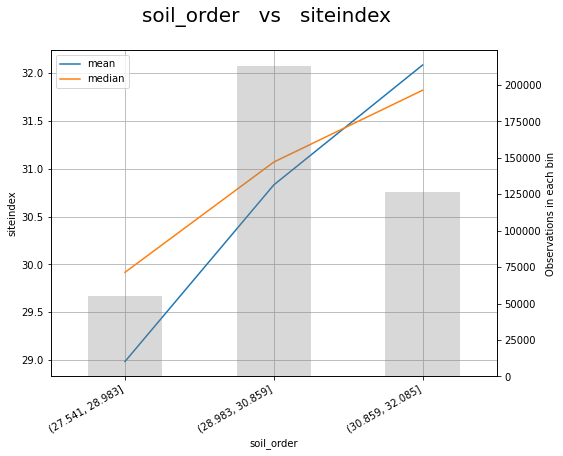

In [ ]:
x, y = "soil_order", "siteindex"

### bin plot
EDAsurvey_noNan = EDAsurvey[EDAsurvey[x].notnull()]
breaks = np.quantile(EDAsurvey_noNan[x], q=np.linspace(0, 1, 11))
groups = EDAsurvey_noNan.groupby([pd.cut(EDAsurvey_noNan[x], bins=breaks, 
           duplicates='drop')])[y].agg(['mean','median','size'])

fig, ax = plt.subplots()
#fig, ax = plt.subplots(nrows=2, ncols=2,  sharex=False, sharey=False)
#fig.suptitle(x+"   vs   "+y, fontsize=20)
fig.set_size_inches(8, 6)

fig.suptitle(x+"   vs   "+y, fontsize=20)
groups[["mean", "median"]].plot(kind="line", ax=ax)
groups["size"].plot(kind="bar", ax=ax, rot=45, secondary_y=True,
                    color="grey", alpha=0.3, grid=True)
ax.set(ylabel=y)
ax.right_ax.set_ylabel("Observations in each bin")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

### scatter plot
#sns.jointplot(x=x, y=y, data=EDAsurvey, dropna=True, kind='reg')
plt.savefig('SOILvsSITE.png', bbox_inches='tight', dpi=300)

### b.2) Plot siteindex group by geology structure

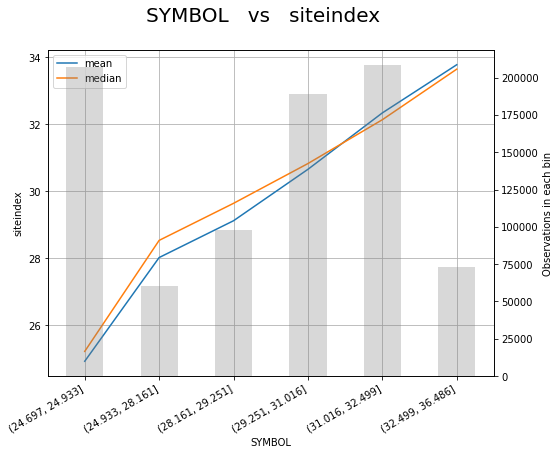

In [ ]:
x, y = "SYMBOL", "siteindex"

### bin plot
EDAsurvey_noNan = EDAsurvey[EDAsurvey[x].notnull()]
breaks = np.quantile(EDAsurvey_noNan[x], q=np.linspace(0, 1, 11))
groups = EDAsurvey_noNan.groupby([pd.cut(EDAsurvey_noNan[x], bins=breaks, 
           duplicates='drop')])[y].agg(['mean','median','size'])

fig, ax = plt.subplots()
#fig, ax = plt.subplots(nrows=2, ncols=2,  sharex=False, sharey=False)
#fig.suptitle(x+"   vs   "+y, fontsize=20)
fig.set_size_inches(8, 6)

fig.suptitle(x+"   vs   "+y, fontsize=20)
groups[["mean", "median"]].plot(kind="line", ax=ax)
groups["size"].plot(kind="bar", ax=ax, rot=45, secondary_y=True,
                    color="grey", alpha=0.3, grid=True)
ax.set(ylabel=y)
ax.right_ax.set_ylabel("Observations in each bin")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

### scatter plot
#sns.jointplot(x=x, y=y, data=EDAsurvey, dropna=True, kind='reg')
plt.savefig('GEOLvsSITE.png', bbox_inches='tight', dpi=300)

In [ ]:
import statistics
from scipy import stats

# Use stats. function to describe the mean of observations
stats.describe(EDAsurvey.SYMBOL)

DescribeResult(nobs=953556, minmax=(24.697480600497528, 36.485791999975575), mean=28.962667390307836, variance=10.87790935341574, skewness=-0.08873828140615538, kurtosis=-1.345323336813257)

## 2 Features selection?

### 2.1 Correlation Analysis: Spearman

In [8]:
# 1.create a copy of dataframe
EDAsurveyCORR = EDAsurvey.copy()

# Remove column  RCODE and DESCRIPT for ML
EDAsurveyCORR.drop(['x', 'y'], inplace = True, axis = 1) 
EDAsurveyCORR.head()

In [ ]:
# 2.correlation with Spearman
spearmancorr = EDAsurveyCORR.corr(method='spearman')
spearmancorr

,siteindex,aspect,planCurvature,profileCurvature,slope,TPI,TWI_SAGA,catchmentArea_SAGA,SVF_simplified,Gh_total,Dh_diffuse,Ih_direct,DEM,distFromCoast,meanJanRain,meanJulRain,maxJanTemp,minJulTemp,SYMBOL,soil_order,BDw,CLY,CFG,ECD,SOC,pHw,SND,SLT
siteindex,1.000000,0.031095,-0.113104,-0.152914,-0.109250,-0.225499,0.215577,0.263748,0.109304,0.124288,-0.114080,0.138781,-0.480185,-0.357393,-0.567263,0.493680,0.040687,0.479417,0.619824,0.349842,-0.374351,0.313318,-0.394741,-0.316842,0.403526,0.099514,-0.155904,-0.024656
aspect,0.031095,1.000000,0.008325,0.024129,0.020777,0.014362,-0.021320,-0.023096,-0.024829,-0.303018,0.028913,-0.342623,0.129647,0.094831,0.099042,-0.031633,-0.023508,-0.071986,-0.105434,-0.052924,0.066600,-0.027509,0.061857,0.058294,-0.068091,-0.053010,0.029981,-0.010560
planCurvature,-0.113104,0.008325,1.000000,0.430254,-0.040650,0.444574,-0.276281,-0.378293,0.041422,0.028265,0.012687,0.018211,0.028098,0.011646,-0.008902,0.025553,-0.009775,0.021413,0.012321,0.026569,-0.013214,-0.004087,-0.009580,-0.001020,0.022764,-0.042422,0.004888,-0.001502
profileCurvature,-0.152914,0.024129,0.430254,1.000000,0.053664,0.524375,-0.246964,-0.387611,-0.054665,-0.016819,-0.002600,-0.011774,0.125581,0.082191,0.049936,-0.003954,-0.067953,-0.047552,-0.058436,-0.019550,-0.007138,-0.072087,0.056167,0.056279,0.015143,-0.105000,0.016931,0.028909
slope,-0.109250,0.020777,-0.040650,0.053664,1.000000,-0.037906,-0.707747,-0.366446,-0.999534,-0.157231,-0.257112,0.001244,0.160963,0.126368,0.118468,-0.034491,0.051913,-0.101223,-0.131773,-0.030860,0.162575,-0.162080,0.051062,0.079121,-0.124926,-0.108045,0.104216,0.002187
TPI,-0.225499,0.014362,0.444574,0.524375,-0.037906,1.000000,-0.435117,-0.679191,0.039918,0.016939,0.026788,-0.001485,0.140014,0.078095,0.037334,0.013706,-0.084777,-0.038512,-0.042498,-0.005764,-0.011918,-0.095425,0.069874,0.056851,0.027039,-0.125518,0.033892,0.025750
TWI_SAGA,0.215577,-0.021320,-0.276281,-0.246964,-0.707747,-0.435117,1.000000,0.874950,0.705461,0.049621,0.128869,-0.050402,-0.164370,-0.082986,-0.076102,-0.000818,-0.067653,0.031445,0.109769,-0.015799,-0.146986,0.144348,-0.075137,-0.026906,0.084072,0.134590,-0.148556,0.062684
catchmentArea_SAGA,0.263748,-0.023096,-0.378293,-0.387611,-0.366446,-0.679191,0.874950,1.000000,0.364026,-0.022910,0.005890,-0.054152,-0.194285,-0.087954,-0.068497,-0.002901,0.001060,0.029877,0.115794,-0.018861,-0.086252,0.139078,-0.120547,-0.022861,0.026690,0.152273,-0.139360,0.064825
SVF_simplified,0.109304,-0.024829,0.041422,-0.054665,-0.999534,0.039918,0.705461,0.364026,1.000000,0.159021,0.259181,0.000288,-0.164907,-0.129367,-0.121046,0.032659,-0.049050,0.100899,0.132810,0.030777,-0.160550,0.160193,-0.049968,-0.079503,0.123155,0.111537,-0.101931,-0.003918
Gh_total,0.124288,-0.303018,0.028265,-0.016819,-0.157231,0.016939,0.049621,-0.022910,0.159021,1.000000,0.604929,0.928411,-0.289948,-0.463202,-0.489901,0.088231,0.460887,0.479500,0.168041,0.402961,-0.043207,0.115397,-0.031169,-0.270716,0.154030,0.149964,0.163133,-0.260665


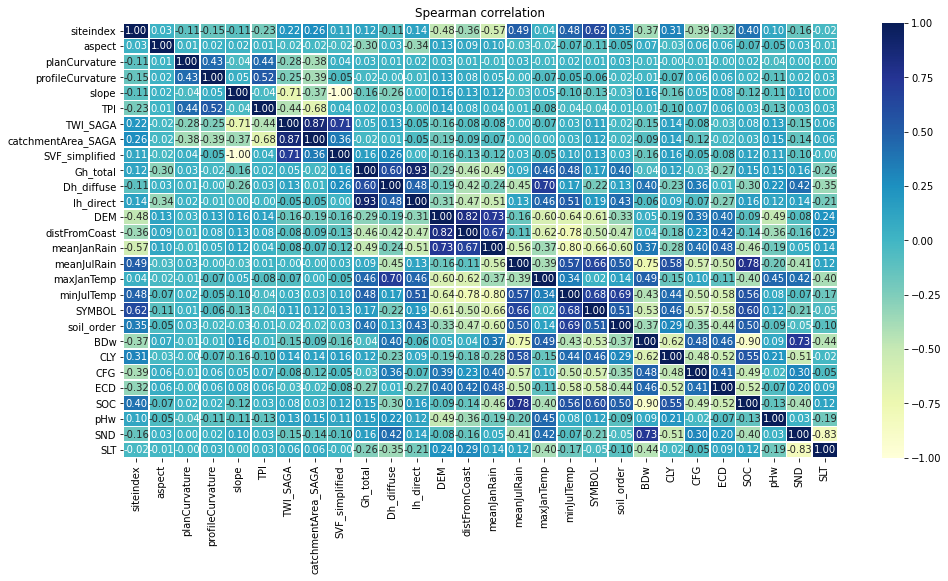

In [ ]:
# 3.correlation with Spearman Improved

plt.figure(figsize=(16,8))

corr_matrix = EDAsurveyCORR.corr(method="spearman")

sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("Spearman correlation")

plt.savefig('Spearmancorr_EDAsurvey.png', bbox_inches='tight', dpi=300)

### 2.2 Drop features high correlated

In [78]:
# Remove 3 columns: less feature importance
EDAsurvey.drop(columns=['catchmentArea_SAGA', 'SVF_simplified', 'Gh_total', 'distFromCoast'], inplace= True, axis = 1) 
#EDAsurvey.head()

#EDAsurvey.shape
#OUTPUT: (953556, 24)

In [7]:
features= list(EDAsurvey.columns)
features

['x',
 'y',
 'siteindex',
 'aspect',
 'planCurvature',
 'profileCurvature',
 'slope',
 'TPI',
 'TWI_SAGA',
 'Dh_diffuse',
 'Ih_direct',
 'DEM',
 'meanJanRain',
 'meanJulRain',
 'maxJanTemp',
 'minJulTemp',
 'SYMBOL',
 'soil_order',
 'BDw',
 'CLY',
 'CFG',
 'ECD',
 'SOC',
 'pHw',
 'SND',
 'SLT']

## 3 Normalize Data

In [9]:
#NORMALIZE
from sklearn.preprocessing import MinMaxScaler

y = EDAsurveyCORR['siteindex']
EDAsurveyCORR = EDAsurveyCORR.loc[:, ~EDAsurveyCORR.columns.isin(['siteindex'])]

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(EDAsurveyCORR)
EDAsurveyCORR.loc[:,:] = scaled_values

EDAsurveyCORR['siteindex'] = y

In [10]:
EDAsurveyCORR.head()

,aspect,planCurvature,profileCurvature,slope,TPI,TWI_SAGA,Dh_diffuse,Ih_direct,DEM,meanJanRain,meanJulRain,maxJanTemp,minJulTemp,SYMBOL,soil_order,BDw,CLY,CFG,ECD,SOC,pHw,SND,SLT,siteindex
0,0.324073,0.445431,0.637699,0.127219,0.524300,0.399242,0.987201,0.974878,0.072357,0.044092,0.184301,0.957136,0.932759,0.409619,0.730319,0.888483,0.236139,0.053705,0.355763,0.038044,0.561864,0.834947,0.185340,27.914452
1,0.271972,0.444238,0.618139,0.117983,0.521429,0.509997,0.988226,0.976873,0.068866,0.042475,0.183347,0.958660,0.934621,0.409619,0.730319,0.889869,0.247779,0.054667,0.368036,0.037626,0.600319,0.836997,0.175913,27.615402
2,0.278898,0.445406,0.610340,0.113273,0.521865,0.530687,0.988683,0.976371,0.067856,0.041899,0.182996,0.959172,0.935292,0.409619,0.730319,0.889948,0.248986,0.054729,0.368189,0.037598,0.602597,0.836463,0.175780,27.474239
3,0.353328,0.445932,0.620043,0.135483,0.523819,0.335656,0.986266,0.973560,0.074708,0.045347,0.185025,0.955888,0.931355,0.409619,0.730319,0.887536,0.228323,0.052748,0.346148,0.038323,0.534801,0.831176,0.194383,27.193528
4,0.336173,0.445418,0.630900,0.131019,0.524329,0.353325,0.986734,0.974377,0.073859,0.044639,0.184609,0.956542,0.932158,0.409619,0.730319,0.887934,0.237401,0.053405,0.345124,0.038164,0.547753,0.827193,0.193354,27.879600


### Boxplot

In [11]:
columns = list(EDAsurveyCORR.columns)
new_column_names = []
for col in columns:
    new_column_names.append(col.replace(' ', '_'))
EDAsurveyCORR.columns = new_column_names

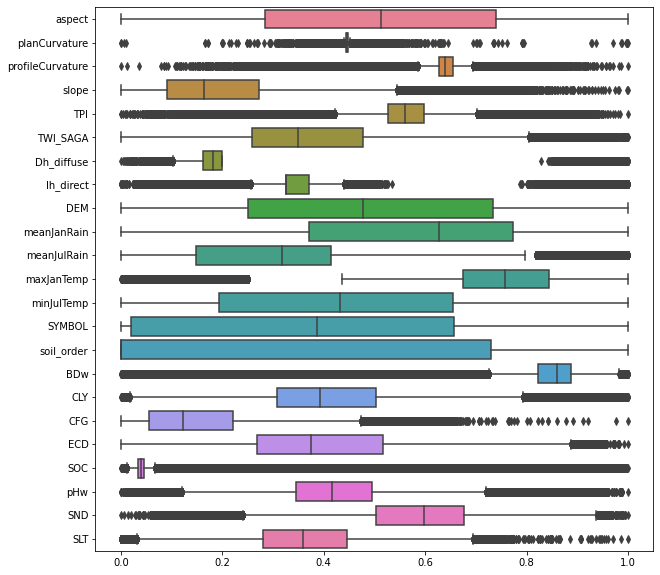

In [12]:
plt.figure(figsize=(10,10))
sns.boxplot(data=EDAsurveyCORR.drop(columns=['siteindex']), orient='horizontal', palette='husl')

### Correlation between features

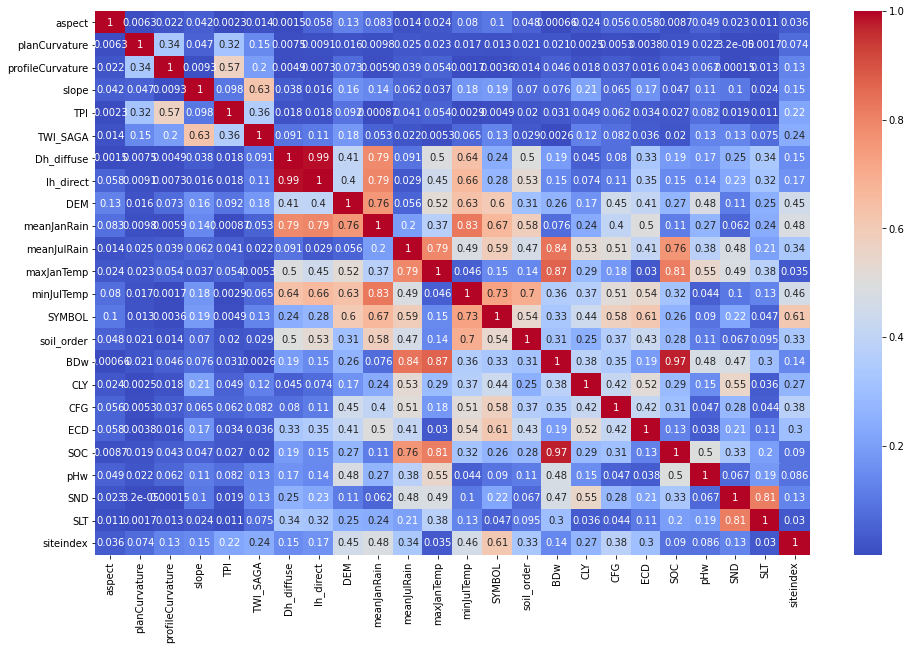

In [13]:
#check correlation after drop 4 features
corr_matrix = EDAsurveyCORR.corr().abs()
plt.figure(figsize=(16,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# 4 Split into training

## 4.1 Split into training: test=10%

In [27]:
# A_Target variable: Labels are the values we want to predict
X = EDAsurvey.drop('siteindex', axis = 1)

# Saving feature names for later use
X_list = list(EDAsurvey.columns)

# B_Independent variables: features are the values that help to predict
y = EDAsurvey['siteindex']#.values.reshape(-1,1)

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', X_test.shape)
print('Testing Features Shape:', y_train.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (858200, 23)
Training Labels Shape: (95356, 23)
Testing Features Shape: (858200,)
Testing Labels Shape: (95356,)


In [20]:
X_train

,aspect,planCurvature,profileCurvature,slope,TPI,TWI_SAGA,Dh_diffuse,Ih_direct,DEM,meanJanRain,meanJulRain,maxJanTemp,minJulTemp,SYMBOL,soil_order,BDw,CLY,CFG,ECD,SOC,pHw,SND,SLT
426806,47.147285,0.006106,-0.000436,19.001930,3.645781,5.682478,0.762135,2.447178,311.972115,25.923939,105.300516,23.896664,2.109279,24.933032,27.540958,1.047972,14.998476,4.921338,0.795499,2.333249,5.482408,54.243139,30.758385
271878,130.024067,0.013685,0.001227,7.697202,2.771841,7.125896,0.779980,2.448878,542.730515,26.392164,101.127244,23.105822,1.367379,24.933032,27.540958,1.010706,15.065409,8.766447,0.752922,3.214279,5.240255,63.979336,20.955255
74289,158.925385,0.007528,0.000490,10.124240,-0.249094,6.295873,1.332510,7.085342,181.783455,7.341604,140.116179,24.358954,4.738370,31.015841,30.859481,0.993557,22.353038,2.516349,0.567430,3.423922,5.453693,61.462594,16.184368
342262,24.852486,0.002746,0.000681,6.305374,4.488536,7.299179,0.781159,2.448974,472.519836,26.080638,106.249624,23.323330,1.543731,24.697481,27.540958,1.001537,14.681975,3.958100,0.926702,3.099175,5.332513,55.257488,30.060537
412732,67.518269,0.043301,0.000909,3.769339,0.692930,7.628614,0.782672,2.448484,430.648178,27.190204,91.232551,23.537464,1.737464,24.933032,27.540958,1.021596,14.627983,14.245522,1.005223,3.173225,5.451697,71.369941,14.002076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,110.553951,-0.001371,0.004404,12.122914,5.816518,7.355519,0.774724,2.447881,573.798553,25.919736,111.199629,22.961182,1.282221,24.697481,27.540958,1.012758,13.981121,4.184853,0.869924,3.074336,5.327276,59.706214,26.312664
365838,111.647617,-0.007901,-0.000707,17.862086,2.484383,6.520496,0.764650,2.448166,466.671974,25.896483,109.759231,23.316859,1.568685,24.697481,27.540958,1.002849,13.637332,9.619968,0.814772,2.889016,5.328176,50.824084,35.538583
131932,11.919937,-0.016890,-0.001627,2.952682,-1.776796,10.219290,1.352519,7.399120,113.623383,5.572667,129.370910,24.552535,5.063813,29.526195,30.859481,0.995126,21.083227,4.504070,0.614642,3.368751,5.640881,60.345940,18.570831
671155,106.259342,0.019825,0.004291,12.622812,1.082844,5.728823,0.739178,2.157390,322.104744,20.481236,227.929941,20.875414,4.604169,30.529839,32.084894,0.388246,26.665044,2.111112,0.797130,27.902804,5.195140,50.347812,22.987144


In [8]:
EDAsurvey.head()

,x,y,siteindex,aspect,planCurvature,profileCurvature,slope,TPI,TWI_SAGA,Dh_diffuse,Ih_direct,DEM,meanJanRain,meanJulRain,maxJanTemp,minJulTemp,SYMBOL,soil_order,BDw,CLY,CFG,ECD,SOC,pHw,SND,SLT
0,508985,5452015,27.914452,58.561249,0.002594,0.000163,5.779576,-1.204296,8.033133,1.359027,7.344204,54.816718,4.617585,111.933050,24.504642,5.596159,29.526195,30.859481,1.018121,12.715149,1.777616,0.621924,3.254319,5.665130,75.630202,11.654650
1,508975,5452035,27.615402,49.200798,-0.007862,-0.001871,5.366687,-1.327446,9.179167,1.359776,7.359235,52.767088,4.569838,111.762547,24.511998,5.604992,29.526195,30.859481,1.019250,13.161926,1.803848,0.635599,3.237924,5.732380,75.776229,11.061845
2,508975,5452045,27.474239,50.445107,0.002370,-0.002682,5.156123,-1.308731,9.393249,1.360110,7.355454,52.174048,4.552800,111.699702,24.514470,5.608177,29.526195,30.859481,1.019314,13.208274,1.805538,0.635770,3.236828,5.736364,75.738196,11.053531
3,508995,5452005,27.193528,63.817375,0.006988,-0.001673,6.149034,-1.224942,7.375174,1.358343,7.334274,56.197104,4.654665,112.062519,24.498619,5.589504,29.526195,30.859481,1.017350,12.415153,1.751514,0.611210,3.265267,5.617801,75.361548,12.223299
4,508995,5452015,27.879600,60.735245,0.002478,-0.000544,5.949467,-1.203051,7.558006,1.358685,7.340429,55.698914,4.633741,111.988205,24.501776,5.593312,29.526195,30.859481,1.017674,12.763595,1.769438,0.610069,3.259003,5.640452,75.077790,12.158615


## 4.2 Extract train and test idx for later merge with geography coord

In [10]:
# Extracting train and test idx for later merge with additional data or geography coordinates
test_idx=np.asarray(X_test.index)
train_idx=np.asarray(X_train.index)

X_test_coord=EDAsurvey[[ 'x', 'y', 'siteindex']].iloc[test_idx]
X_test_coord.reset_index(inplace=True,drop=True)

#test_idx

In [11]:
X_test.shape
#output: (95356, 25)

(95356, 25)

In [69]:
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

AttributeError: ignored

In [80]:
# drop coordinates
EDAsurvey.drop(columns=['x', 'y'], inplace= True, axis = 1) 

In [81]:
EDAsurvey.head()

,siteindex,aspect,planCurvature,profileCurvature,slope,TPI,TWI_SAGA,Dh_diffuse,Ih_direct,DEM,meanJanRain,meanJulRain,maxJanTemp,minJulTemp,SYMBOL,soil_order,BDw,CLY,CFG,ECD,SOC,pHw,SND,SLT
0,27.914452,58.561249,0.002594,0.000163,5.779576,-1.204296,8.033133,1.359027,7.344204,54.816718,4.617585,111.933050,24.504642,5.596159,29.526195,30.859481,1.018121,12.715149,1.777616,0.621924,3.254319,5.665130,75.630202,11.654650
1,27.615402,49.200798,-0.007862,-0.001871,5.366687,-1.327446,9.179167,1.359776,7.359235,52.767088,4.569838,111.762547,24.511998,5.604992,29.526195,30.859481,1.019250,13.161926,1.803848,0.635599,3.237924,5.732380,75.776229,11.061845
2,27.474239,50.445107,0.002370,-0.002682,5.156123,-1.308731,9.393249,1.360110,7.355454,52.174048,4.552800,111.699702,24.514470,5.608177,29.526195,30.859481,1.019314,13.208274,1.805538,0.635770,3.236828,5.736364,75.738196,11.053531
3,27.193528,63.817375,0.006988,-0.001673,6.149034,-1.224942,7.375174,1.358343,7.334274,56.197104,4.654665,112.062519,24.498619,5.589504,29.526195,30.859481,1.017350,12.415153,1.751514,0.611210,3.265267,5.617801,75.361548,12.223299
4,27.879600,60.735245,0.002478,-0.000544,5.949467,-1.203051,7.558006,1.358685,7.340429,55.698914,4.633741,111.988205,24.501776,5.593312,29.526195,30.859481,1.017674,12.763595,1.769438,0.610069,3.259003,5.640452,75.077790,12.158615


# 5 Fit Model: Linear Model | Ordinary Least Squares Method

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

# Create a linear regression object
model = linear_model.LinearRegression()

# TRAIN: Fit the model using the training set
model.fit(X_train, y_train)

# TEST: Make prediction using test set
predictedStand = model.predict(X_test)
predictedStand

array([28.42077401, 22.03108336, 30.06839684, ..., 33.63586926,
       22.25192064, 29.54868316])

## 5.1 Evaluation Model: R-squared and regression coeff

In [23]:
from sklearn.metrics import mean_squared_error, r2_score
# Model Output
# a. Intercept
print("Intercept:", model.intercept_)

# b. Coefficient - the slop of the line
print("Coefficients(slope of the line):", model.coef_)

# c. the error - the mean square error
print("Mean squared error: %.2f"% mean_squared_error(y_test,predictedStand))

# d. R-square -  how well x accout for the varaince of Y
print("R-square: %.2f'" % r2_score(y_test,predictedStand))

Intercept: [19.45632165]
Coefficients(slope of the line): [[ 1.38178661e-02 -1.30463257e+00  4.25469795e+00 -2.26624835e-02
  -3.59106629e-01  2.13275439e-01 -1.92066505e+01  5.21259431e-01
   1.22582210e-02 -4.36366346e-01  6.23360933e-03  1.67601710e+00
   1.29457440e+00  6.65419460e-01  9.42815995e-02 -3.28981861e+00
  -2.30492547e-01 -1.39943747e-02  3.85348300e+00 -1.37412570e-01
  -2.10723043e+00 -2.69199822e-01 -2.86898511e-01]]
Mean squared error: 14.84
R-square: 0.49'


In [24]:
#1.Run split into training
#y = EDAsurvey['siteindex'].values.reshape(-1,1)
#2. run model again

pred_model = pd.DataFrame(['aspect','planCurvature','profileCurvature','slope','TPI','TWI_SAGA','Dh_diffuse','Ih_direct','DEM','meanJanRain','meanJulRain','maxJanTemp','minJulTemp','SYMBOL','soil_order','BDw','CLY','CFG','ECD','SOC','pHw','SND','SLT'])
coeff = pd.DataFrame(model.coef_, index=['Co-efficient']).transpose() 

In [25]:
pd.concat([pred_model,coeff], axis=1, join='inner')

,0,Co-efficient
0,aspect,0.013818
1,planCurvature,-1.304633
2,profileCurvature,4.254698
3,slope,-0.022662
4,TPI,-0.359107
5,TWI_SAGA,0.213275
6,Dh_diffuse,-19.206651
7,Ih_direct,0.521259
8,DEM,0.012258
9,meanJanRain,-0.436366


### 5.1.0 Plot Evaluation Model

In [29]:
column_names = ['aspect','planCurvature', 'profileCurvature','slope','TPI','TWI_SAGA','Dh_diffuse','Ih_direct','DEM','meanJanRain','meanJulRain','maxJanTemp','minJulTemp','SYMBOL','soil_order','BDw','CLY', 'CFG','ECD','SOC','pHw','SND','SLT']

regression_coefficient = pd.DataFrame({'Feature': column_names, 'Coefficient': model.coef_}, columns=['Feature', 'Coefficient'])

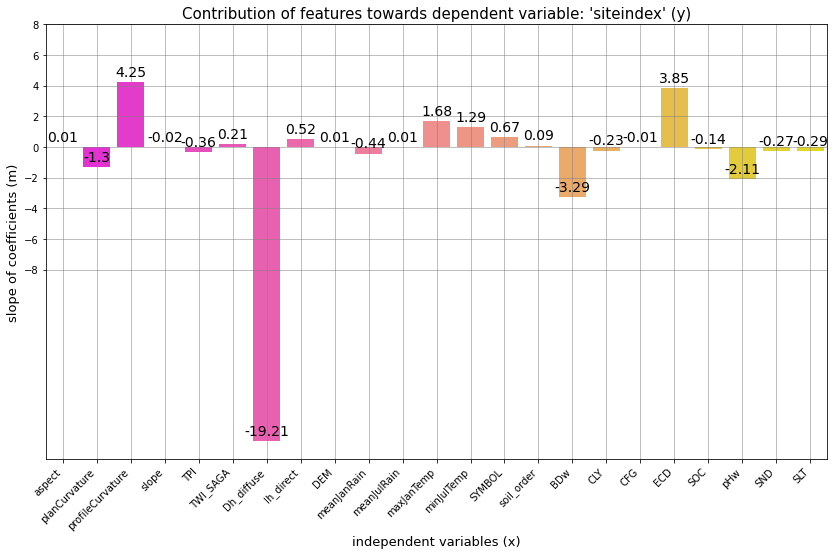

In [30]:
plt.figure(figsize=(14,8))
g = sns.barplot(x='Feature', y='Coefficient', data=regression_coefficient, capsize=0.3, palette='spring')
g.set_title("Contribution of features towards dependent variable: 'siteindex' (y)", fontsize=15)
g.set_xlabel("independent variables (x)", fontsize=13)
g.set_ylabel("slope of coefficients (m)", fontsize=13)
plt.xticks(rotation=45, horizontalalignment='right')
g.set_yticks([-8, -6, -4, -2, 0, 2, 4, 6, 8])
g.set_xticklabels(column_names)
for p in g.patches:
    g.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), 
               textcoords='offset points', fontsize=14, color='black')
    
plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
#plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')


plt.savefig('regCoef_linearModel_10test.png', bbox_inches='tight', dpi=300)

### 5.1.1 Set perfomance: Actual vs Predicted

In [66]:
#Investigating Train set performance
model.score(X_train, y_train)

0.4917335497244104

In [58]:
#Investigating Test set performance
model.score(X_test, y_test)

0.48769422894698217

In [59]:
dataStand = pd.DataFrame({'Actual': y_test, 'Predicted': predictedStand})
dataStand

,Actual,Predicted
0,28.859368,28.420774
1,24.855434,22.031083
2,29.188636,30.068397
3,33.722814,30.768541
4,26.763467,26.860028
...,...,...
95351,31.985134,28.141165
95352,31.953531,25.936747
95353,33.282146,33.635869
95354,24.566475,22.251921


### 5.1.2 Bar Plot: Actual vs Predicted

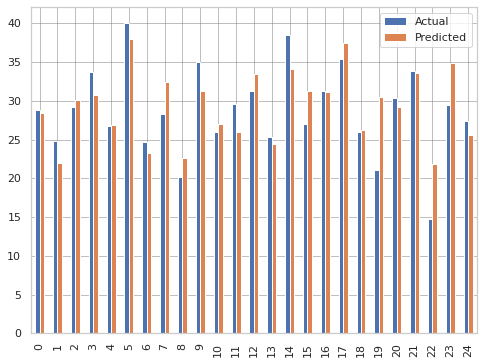

In [60]:
import numpy as np   # To perform calculations
import matplotlib.pyplot as plt  # To visualize data and regression line
from pylab import rcParams
import seaborn as sns

sns.set(style="whitegrid")

dfStand = dataStand.head(25)
dfStand.plot(kind='bar', figsize=(8,6))

plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### 5.1.3 Validations

In [ ]:
#explained_variance=metrics.explained_variance_score(y_train, y_train_mlr)
#r2 = metrics.r2_score(y_train, y_train_mlr)
#mean_absolute_error=metrics.mean_absolute_error(y_train, y_train_mlr) 
#mse = metrics.mean_squared_error(y_train, y_train_mlr) 
#median_absolute_error = metrics.median_absolute_error(y_train, y_train_mlr)

In [217]:
## Kpi
print("R2 (explained variance):", round(metrics.r2_score(y_test, predictedStand), 2))
print("MAE=Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predictedStand)))
print("MAPE=Mean Absolute Percentage Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test-predictedStand)/predictedStand)), 2))
print("MSE=Mean Square Error (Σ(y-pred)^2/n):", "{:,.0f}".format(metrics.mean_squared_error(y_test, predictedStand)))
print("RMSE=Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, predictedStand))))

## residuals
residuals = y_test - predictedStand
max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
max_true, max_pred = y_test[max_idx], predictedStand[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))

R2 (explained variance): 0.49
MAE=Mean Absolute Error (Σ|y-pred|/n): 3
MAPE=Mean Absolute Percentage Error (Σ(|y-pred|/y)/n): 0.1
MSE=Mean Square Error (Σ(y-pred)^2/n): 15
RMSE=Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 4
Max Error: -30


### Plot Validation: Predicted vs True (Residuals)

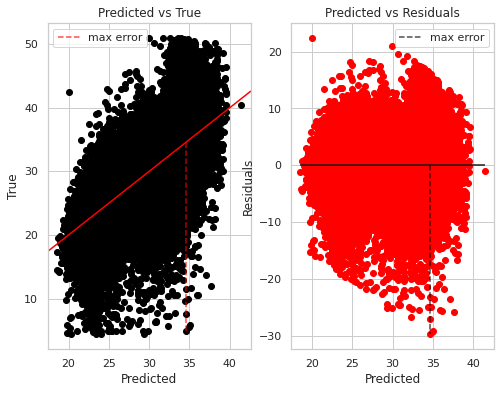

In [62]:
## Plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(8,6))

from statsmodels.graphics.api import abline_plot

ax[0].scatter(predictedStand, y_test, color="black")
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].vlines(x=max_pred, ymin=max_true, ymax=max_true-max_error, color='red', linestyle='--', alpha=0.7, label="max error")
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()

## Plot predicted vs residuals
ax[1].scatter(predictedStand, residuals, color="red")
ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color='black', linestyle='--', alpha=0.7, label="max error")
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(predictedStand), xmax=np.max(predictedStand))
ax[1].legend()
plt.show()

# 6 Regression assumptions

In [63]:
error = y_test - predictedStand
error_info = pd.DataFrame({'y_true': y_test, 'y_pred': predictedStand, 'error': error}, columns=['y_true', 'y_pred', 'error'])

## 6.1 Correlation of errors

Text(0, 0.5, 'Residual')

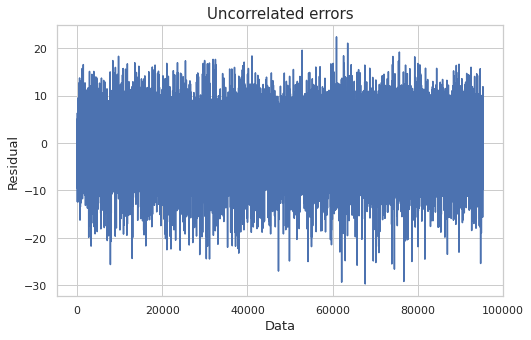

In [64]:
fig, ax = plt.subplots(figsize=(8,5))
ax = error_info.error.plot()
ax.set_title('Uncorrelated errors', fontsize=15)
ax.set_xlabel("Data", fontsize=13)
ax.set_ylabel("Residual", fontsize=13)

## 6.2 Normality of error terms: Probability Plot




Text(0, 0.5, 'Ordered Values')

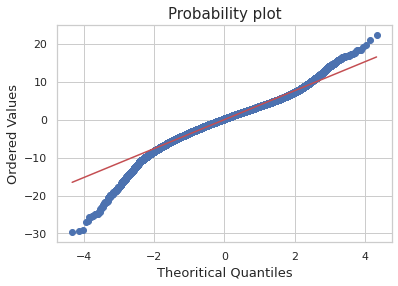

In [65]:
#plotting probability probability plot(p-p plot) 
import scipy as sp

fig, ax = plt.subplots(figsize=(6,4))
_ = sp.stats.probplot(error_info.error, plot=ax, fit=True)
ax.set_title('Probability plot', fontsize=15)
ax.set_xlabel("Theoritical Quantiles", fontsize=13)
ax.set_ylabel("Ordered Values", fontsize=13)


# 7 Fit Model: Linear model | K-fold Cross Validation

## 7.1. Fit model with 10-fold cross-validation with all features

In [200]:
from sklearn.model_selection import cross_val_score
lm = LinearRegression()

scores10 = cross_val_score(lm, X_train, y_train, cv=10, scoring='r2')
print("Cross-validation scores: {}".format(scores10))

Cross-validation scores: [0.49047995 0.48809305 0.49003367 0.49691588 0.49015229 0.4932876
 0.49022728 0.49104513 0.49085065 0.49598045]


In [201]:
print("Average cross-validation score: {:.2f}".format(scores10.mean()))

Average cross-validation score: 0.49


In [202]:
#The mean score and the 95% confidence interval of the score estimate are hence given by:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores10.mean(), scores10.std() * 2))

Accuracy: 0.49 (+/- 0.01)


## 7.2 Validation

In [215]:
print("R2 (explained variance):", round(metrics.r2_score(y_test, predictedStand), 2))
print('MAE=Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictedStand))  
print('MSE=Mean Squared Error:', metrics.mean_squared_error(y_test, predictedStand))  
print('RMSE=Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictedStand)))

R2 (explained variance): 0.49
MAE=Mean Absolute Error: 2.918087551161566
MSE=Mean Squared Error: 14.838860605080836
RMSE=Root Mean Squared Error: 3.8521241679209712


## 7.3 Plot Validation: Predicted vs Observed

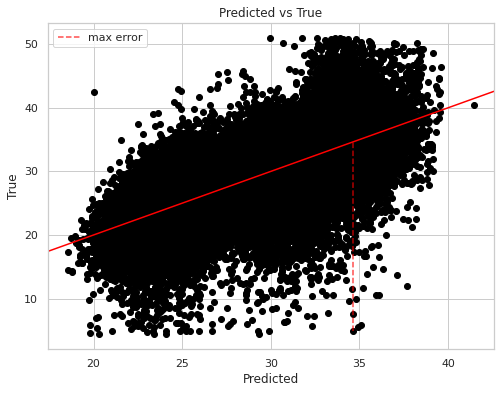

In [ ]:

## Plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,6))

ax.scatter(predictedStand, y_test, color="black")
abline_plot(intercept=0, slope=1, color="red", ax=ax)
ax.vlines(x=max_pred, ymin=max_true, ymax=max_true-max_error, color='red', linestyle='--', alpha=0.7, label="max error")
ax.grid(True)
ax.set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax.legend()

plt.show()

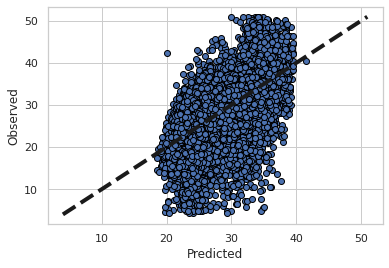

In [ ]:
fig, ax = plt.subplots()
ax.scatter(predicted, y_test, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Predicted')
ax.set_ylabel('Observed')
plt.show()

## 7.4 Evaluating Linear Regression Models

In [31]:
from sklearn.model_selection import cross_val_score

# function to get cross validation scores
def get_cv_scores(model):
    scores = cross_val_score(model,
                             X_train,
                             y_train,
                             cv=10,
                             scoring='r2')
    
    print('CV Mean: ', np.mean(scores))
    print('STD: ', np.std(scores))
    print('\n')

### 7.4.1 Linear Model | Ordinary Least Squares

In [32]:
lm = LinearRegression()
# get cross val scores
get_cv_scores(lm)

CV Mean:  0.4917065958099019
STD:  0.002665286683619082




### 7.4.2 Linear Model | Lasso

In [35]:
from sklearn.linear_model import Lasso
# Train model with default alpha=1
lasso = Lasso(alpha=0.1).fit(X_train, y_train)
# get cross val scores
get_cv_scores(lasso)

CV Mean:  0.47569434955004786
STD:  0.0027149976210637736




In [222]:
# find optimal alpha with grid search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed: 10.2min finished


Best Score:  0.4913320365427035
Best Params:  {'alpha': 0.001}


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6204191.748435324, tolerance: 2519.0378299386025
  positive)


In [36]:
from sklearn.linear_model import Lasso
# Train model with default alpha=1
lasso = Lasso(alpha=0.001, max_iter=100000).fit(X_train, y_train)
# get cross val scores
get_cv_scores(lasso)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3161562.697758381, tolerance: 2519.0378299386025
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2803584.10591027, tolerance: 2266.3232140403825
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2905977.6317616403, tolerance: 2266.19852078212
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2826861.504

CV Mean:  0.4913589411193605
STD:  0.002640644700328392




/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2859157.990354161, tolerance: 2265.357114172313
  positive)


In [37]:
print("Training set score: {:.2f}".format(lasso.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(lasso.coef_!=0)))

Training set score: 0.49
Test set score: 0.49
Number of features used: 21


In [38]:
# match column names to coefficients
for coef, col in enumerate(X_train.columns):
    print(f'{col}:  {lasso.coef_[coef]}')


aspect:  0.013343895250438637
planCurvature:  -0.8078355103910868
profileCurvature:  0.0
slope:  -0.014930412549500602
TPI:  -0.3503804371269268
TWI_SAGA:  0.2195434406336073
Dh_diffuse:  -14.272911287400094
Ih_direct:  0.34226690515021596
DEM:  0.006995608364730471
meanJanRain:  -0.4321753841212667
meanJulRain:  0.00038172811794823886
maxJanTemp:  0.6419318868790536
minJulTemp:  0.646181739151513
SYMBOL:  0.6687960596786054
soil_order:  0.0837795415682644
BDw:  -0.0
CLY:  0.037686188117202715
CFG:  -0.010602830207502353
ECD:  3.802613307542145
SOC:  -0.0700527163360008
pHw:  -2.022245482976454
SND:  -0.009410600627715501
SLT:  -0.021653271266683056


# 8 Fit: Decision Tree

In [121]:
# 3. Split into training
y = EDAsurvey.siteindex
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [122]:
#1.Import Model to use
from sklearn.tree import DecisionTreeClassifier

#2.Make an instance of Decision Tree Model
modelDTree = DecisionTreeClassifier(max_depth = 2, random_state = 0)

In [92]:
# 4.Train the Model
modelDTree.fit(X_train, y_train.astype('int'))

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [112]:
# 5. Predict labels of unseen Test Data

# 5.0  Predicting the Test set results
y_pred = modelDTree.predict(X_test)

# 5.1 Predict for 1 observation
#modelDTree.predict(X_test.iloc[0].values.reshape(1, -1))

# 5.2 Predict for multiple observations
#modelDTree.predict(X_test[0:10])

In [113]:
# 6. The score method returns the accuracy of the model (Measure Model Perfomance)
score = modelDTree.score(X_test, y_test.astype('int'))
print(score)

0.1252464449012123


In [116]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test.astype('int'), y_pred)
print(accuracy )

0.1252464449012123


In [103]:
# 7. Tunning the Depth of Tree

# List of values to try for max_depth:
max_depth_range = list(range(1, 6))
# List to store the average RMSE for each value of max_depth:
accuracy = []
for depth in max_depth_range:
    
    modelDTree = DecisionTreeClassifier(max_depth = depth, random_state = 0)

    modelDTree.fit(X_train, y_train.astype('int'))
    score = modelDTree.score(X_test, y_test.astype('int'))
    accuracy.append(score)

accuracy

[0.10241620873358782,
 0.11430848609421536,
 0.11701413649901422,
 0.12251982046226771,
 0.1252464449012123]

In [102]:
# 8. Feature Importance
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(modelDTree.feature_importances_,3)})

importances = importances.sort_values('importance',ascending=False)
importances

,feature,importance
9,meanJanRain,0.530
12,minJulTemp,0.115
4,TPI,0.104
8,DEM,0.090
11,maxJanTemp,0.038
0,aspect,0.035
13,SYMBOL,0.031
5,TWI_SAGA,0.021
15,BDw,0.013
6,Dh_diffuse,0.008


# 9 Fit: Random Forest

In [ ]:

svm_reg=svm.SVR()
svm_reg.fit(EDAsurvey.drop(columns=['siteindex']),EDAsurvey.siteindex)
y1_svm=svm_reg.predict(EDAsurvey.drop(columns=['siteindex']))
r2_svm = r2_score(y_true, y1_svm)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import svm
from sklearn import tree
from sklearn import neighbors
from sklearn import linear_model

r2_list = [r2_linear_regression, r2_ridge, r2_knn, r2_dt, r2_bayesian, r2_svm]
r2_names = ['Linear Regression', 'Ridge Regression', 'KNN', 'Decision Tree', 'Bayesian Regression', 'SVM']

col = {'R-squared':r2_list, 'Method':r2_names}
df = pd.DataFrame(data=col, columns=['Method', 'R-squared'])



NameError: ignored

In [124]:
EDAsurvey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953556 entries, 0 to 953555
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   siteindex         953556 non-null  float64
 1   aspect            953556 non-null  float64
 2   planCurvature     953556 non-null  float64
 3   profileCurvature  953556 non-null  float64
 4   slope             953556 non-null  float64
 5   TPI               953556 non-null  float64
 6   TWI_SAGA          953556 non-null  float64
 7   Dh_diffuse        953556 non-null  float64
 8   Ih_direct         953556 non-null  float64
 9   DEM               953556 non-null  float64
 10  meanJanRain       953556 non-null  float64
 11  meanJulRain       953556 non-null  float64
 12  maxJanTemp        953556 non-null  float64
 13  minJulTemp        953556 non-null  float64
 14  SYMBOL            953556 non-null  float64
 15  soil_order        953556 non-null  float64
 16  BDw               95